# Using Alexrank - Amazon Web Traffic as Predictor of JETS ETF

## Installing & Loading Necessary Packages 


In [1]:
install.packages("rvest") #A Web-Scrapping Package
install.packages("magrittr")
install.packages("stringr")
install.packages("quantmod")
install.packages("RMySQL")
install.packages("dplyr")

library(rvest)
library(magrittr)
library(stringr)
library(quantmod)
library(RMySQL)
library(dplyr)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘xts’, ‘zoo’, ‘TTR’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Loading required package: xts

Loading required package: zoo


Attaching package: ‘zoo’


The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric


Loading required package: TTR

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 

Loading required package: DBI


Attaching package: ‘dplyr’


The following objects are masked from ‘package:xts’:

    first, last


The foll

## Loading the scrapped data from Alexarank

In [2]:
queryMySQL = function(statement) {
  con = dbConnect(MySQL(), host = "147.8.122.231", user = "fina_4359_u3548379", password = "856e7")
  response = dbGetQuery(con,statement)
  dbDisconnect(con)

  return(response)  
}

queryMySQL("show tables in writeable_fina_4359_u3548379")

#lapply(dbListConnections(dbDriver( drv = "MySQL")), dbDisconnect)

Tables_in_writeable_fina_4359_u3548379
<chr>
JETS
TSA
alexarank_daily_by_individual_companies
alexarank_daily_cummulative
alexarank_weekly_cummulative
google_trends_weekly_data
visits


In [3]:
con = dbConnect(MySQL(), host = "147.8.122.231", user = "fina_4359_u3548379", password = "856e7", dbname = "writeable_fina_4359_u3548379")
amazon_trends = queryMySQL("select * from writeable_fina_4359_u3548379.alexarank_weekly_cummulative")

In [4]:
amazon_trends$date = substr(amazon_trends$Date,1,10)
amazon_trends$date = as.Date(amazon_trends$date)
head(amazon_trends)

,Date,Weekly Sum PageViews - PerMillion,Weekly Sum PageViews - PerUser,Weekly Sum Reach - PerMillion,Weekly Average PageViews - PerMillion,Weekly Average PageViews - PerUser,Weekly Average Reach - PerMillion,date
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<date>
1,2019-12-30,12168.7,258.9,92516,1738.386,36.98571,13216.57,2019-12-30
2,2020-01-06,11598.4,267.6,91950,1656.914,38.22857,13135.71,2020-01-06
3,2020-01-13,11766.8,261.7,91850,1680.971,37.38571,13121.43,2020-01-13
4,2020-01-20,11309.9,264.7,90412,1615.700,37.81429,12916.00,2020-01-20
5,2020-01-27,10664.6,266.2,87040,1523.514,38.02857,12434.29,2020-01-27
6,2020-02-03,11102.5,269.0,90100,1586.071,38.42857,12871.43,2020-02-03


## Downloading JETS ETF Data

In [15]:
# websites=c("Tripadvisor", "Booking","Trip", "Expedia","Hotels", "Airbnb", "Agoda", "Priceline", "Skyscanner", "Trivago")
# tickers = c("TRIP", "BKNG", "ABNB", "EXPE", "TRVG")
chosen = "JETS"
print(paste("Chosen Ticker:",chosen))
getSymbols(chosen)
ticker = eval(parse(text=chosen))[,-c(1:5)]
colnames(ticker)[1] = "price"

adj_JETS = data.frame(date = as.Date("1990-01-01"), price = 0)
for (num_row in 1:nrow(ticker)) {
  adj_JETS[num_row,1] = index(ticker)[num_row]
  adj_JETS[num_row,2] = ticker[num_row,1]
}

tail(adj_JETS)

[1] "Chosen Ticker: JETS"


[1] "JETS"

,date,price
,<date>,<dbl>
1523,2021-05-17,26.55
1524,2021-05-18,26.57
1525,2021-05-19,26.27
1526,2021-05-20,26.03
1527,2021-05-21,25.94
1528,2021-05-24,26.31


## Downloading S&P 500 Data

In [16]:
getSymbols("^GSPC")

SPX = GSPC[,-c(1:5)]
colnames(SPX)[1] = "price"

adj_SPX = data.frame(date = as.Date("1990-01-01"), price = 0)
for (num_row in 1:nrow(SPX)) {
  adj_SPX[num_row,1] = index(SPX)[num_row]
  adj_SPX[num_row,2] = SPX[num_row,1]
}

tail(adj_SPX)

[1] "^GSPC"

,date,price
,<date>,<dbl>
3618,2021-05-17,4163.29
3619,2021-05-18,4127.83
3620,2021-05-19,4115.68
3621,2021-05-20,4159.12
3622,2021-05-21,4155.86
3623,2021-05-24,4197.05


## Downloading Risk-Free Rate (10Y US Govn't Treasuries Yield)

In [17]:
getSymbols("DGS10", src = "FRED")

rf = data.frame(date = as.Date("1990-01-01"), yield = 0)


for (num_row in 1:nrow(DGS10)) {
  rf[num_row,1] = index(DGS10)[num_row]
  rf[num_row,2] = DGS10[num_row,1]
}

#Linearly Interpolating Missing Value
  
for (num_row in 2:nrow(rf)) {
  if (is.na(rf[num_row,2]) == TRUE) {
    rf[num_row,2] = (rf[num_row-1,2] + rf[num_row+1,2])/2
  }
}

head(rf)

[1] "DGS10"

,date,yield
,<date>,<dbl>
1,1962-01-02,4.06
2,1962-01-03,4.03
3,1962-01-04,3.99
4,1962-01-05,4.02
5,1962-01-08,4.03
6,1962-01-09,4.05


## Merging Daily JETS ETF Data & Alexrank Data 

In [18]:
amazon_trends_cummulative = amazon_trends %>% select(date, "Weekly Sum PageViews - PerMillion", "Weekly Sum Reach - PerMillion")
head(amazon_trends_cummulative)

,date,Weekly Sum PageViews - PerMillion,Weekly Sum Reach - PerMillion
,<date>,<dbl>,<dbl>
1,2019-12-30,12168.7,92516
2,2020-01-06,11598.4,91950
3,2020-01-13,11766.8,91850
4,2020-01-20,11309.9,90412
5,2020-01-27,10664.6,87040
6,2020-02-03,11102.5,90100


In [19]:
merge(adj_JETS, amazon_trends_cummulative, by = "date", all.x = TRUE) %>% merge(adj_SPX, by = "date", all.x = TRUE) %>% merge(rf, by = "date", all.x = TRUE) -> regression_data
colnames(regression_data)[c(2,5)] = c("JETS_price", "SPX")
head(regression_data)

,date,JETS_price,Weekly Sum PageViews - PerMillion,Weekly Sum Reach - PerMillion,SPX,yield
,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,2015-04-30,23.19987,NA,NA,2085.51,2.05
2,2015-05-01,23.85401,NA,NA,2108.29,2.12
3,2015-05-04,23.65258,NA,NA,2114.49,2.16
4,2015-05-05,23.01955,NA,NA,2089.46,2.19
5,2015-05-06,23.00037,NA,NA,2080.15,2.25
6,2015-05-07,23.44157,NA,NA,2088.00,2.18


## Transform Daily Data into Weekly Data

In [20]:
temp_JETS <- as.xts(regression_data["JETS_price"], order.by = as.Date(regression_data$date)) %>% to.weekly(indexAt = "startof") 
temp_JETS <- temp_JETS["2019-12-23/2021"]

temp_SPX <- as.xts(regression_data$SPX, order.by = as.Date(regression_data$date)) %>% to.weekly(indexAt = "startof") 
temp_SPX <- temp_SPX["2019-12-30/2021"]

temp_yield <- as.xts(regression_data$yield, order.by = as.Date(regression_data$date)) %>% to.weekly(indexAt = "startof")
temp_yield <- temp_yield["2019-12-30/2021"]

temp_g_trends <- as.xts(amazon_trends_cummulative["Weekly Sum PageViews - PerMillion"], order.by = as.Date(amazon_trends_cummulative$date)) %>% to.weekly(indexAt = "startof")
temp_g_trends <- temp_g_trends["2019-12-30/2021"]

temp_g_trends_avg <- as.xts(amazon_trends_cummulative["Weekly Sum Reach - PerMillion"], order.by = as.Date(amazon_trends_cummulative$date)) %>% to.weekly(indexAt = "startof")
temp_g_trends_avg <- temp_g_trends_avg["2019-12-30/2021"]

regression_data_weekly = data.frame(date = as.Date("1990-01-01"), JETS_closing_price = 0, Amazon_Pageview_PerMillion =0, Amazon_Reach_PerMillion =0, SPX = 0, yield = 0)

for (i in 1:nrow(temp_g_trends)) {
  regression_data_weekly[i,1] = index(temp_g_trends)[i]  
  regression_data_weekly[i,2] = temp_JETS[i,4]
  regression_data_weekly[i,3] = temp_g_trends[i,1]
  regression_data_weekly[i,4] = temp_g_trends_avg[i,1]
  regression_data_weekly[i,5] = temp_SPX[i,1]
  regression_data_weekly[i,6] = temp_yield[i,1]
}

if (Sys.Date() >= regression_data_weekly[nrow(temp_g_trends),1]) {
  regression_data_weekly <- regression_data_weekly[-nrow(temp_g_trends),]
}

head(regression_data_weekly,20)

#Consider trying 2020-04-06

Warning message in to.period(x, "weeks", name = name, ...):
“missing values removed from data”


,date,JETS_closing_price,Amazon_Pageview_PerMillion,Amazon_Reach_PerMillion,SPX,yield
,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,2019-12-30,31.60126,12168.70,92516,3221.29,1.90
2,2020-01-06,31.15744,11598.40,91950,3246.28,1.81
3,2020-01-13,31.34636,11766.80,91850,3288.13,1.85
4,2020-01-20,32.23700,11309.90,90412,3320.79,1.78
5,2020-01-27,31.26839,10664.60,87040,3243.63,1.61
6,2020-02-03,29.82797,11102.50,90100,3248.92,1.54
7,2020-02-10,30.79758,11487.90,89604,3352.09,1.56
8,2020-02-17,31.32137,10940.00,90281,3370.29,1.55
9,2020-02-24,30.42973,10253.70,83812,3225.89,1.38


# Prepare Data for Regression

In [21]:
to_regress = data.frame(date = as.Date("1990-01-01"), JETS_weekly_return = 0, Amazon_Pageview_Weekly_Change =0, Amazon_Reach_Weekly_Change=0,SPX_weekly_return = 0,JETS_weekly_excess_return=0,	SPX_weekly_excess_return =0, JETS_rebased = 0, Amazon_Pageview_rebased=0, SPX_rebased=0)
for(i in 1:nrow(regression_data_weekly))
{
   if (i == 1) {
      to_regress[i,1] = regression_data_weekly[i,1]
      to_regress[i,8] = 1
      to_regress[i,9] = 1
      to_regress[i,10] = 1
    } 
    else{
 to_regress[i,1] = regression_data_weekly[i,1]
 to_regress[i,2] = (regression_data_weekly[i,2]-regression_data_weekly[i-1,2])/regression_data_weekly[i-1,2]
 to_regress[i,3] = (regression_data_weekly[i,3]-regression_data_weekly[i-1,3])/regression_data_weekly[i-1,3]
 to_regress[i,4] = (regression_data_weekly[i,4]-regression_data_weekly[i-1,4])/regression_data_weekly[i-1,4]
 to_regress[i,5] = (regression_data_weekly[i,5]-regression_data_weekly[i-1,5])/regression_data_weekly[i-1,5]
 to_regress[i,6] = (regression_data_weekly[i,2]-regression_data_weekly[i-1,2])/regression_data_weekly[i-1,2] - regression_data_weekly[i,6]/52/100
 to_regress[i,7] = (regression_data_weekly[i,5]-regression_data_weekly[i-1,5])/regression_data_weekly[i-1,5] - regression_data_weekly[i,6]/52/100
 to_regress[i,8] = to_regress[i-1,8] * (1 + to_regress[i,2])
 to_regress[i,9] = to_regress[i-1,9] * (1 + to_regress[i,3])
 to_regress[i,10] = to_regress[i-1,10] * (1 + to_regress[i,5])
    }
}
tail(to_regress,20)


,date,JETS_weekly_return,Amazon_Pageview_Weekly_Change,Amazon_Reach_Weekly_Change,SPX_weekly_return,JETS_weekly_excess_return,SPX_weekly_excess_return,JETS_rebased,Amazon_Pageview_rebased,SPX_rebased
,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
53,2020-12-28,-0.016422597,0.111982592,0.059077601,0.0109448069,-0.016603367,0.0107640377,0.7009552,0.7433169,1.159585
54,2021-01-04,0.010334987,-0.100625746,-0.088237804,-0.0092923317,0.010156141,-0.0094711778,0.7081996,0.6685201,1.148810
55,2021-01-11,-0.008042806,-0.186674403,-0.039096422,0.0267413043,-0.008263960,0.0265201504,0.7025037,0.5437245,1.179531
56,2021-01-18,0.003603603,-0.002159778,-0.034123444,-0.0001842807,0.003392065,-0.0003958192,0.7050352,0.5425501,1.179313
57,2021-01-25,-0.001346544,0.099842021,0.054848662,0.0148595772,-0.001548467,0.0146576541,0.7040859,0.5967195,1.196837
58,2021-02-01,-0.039101169,-0.039721537,-0.035384527,-0.0211394001,-0.039310784,-0.0213490155,0.6765553,0.5730168,1.171537
59,2021-02-08,0.078110387,0.065859538,0.067162109,0.0375557061,0.077881541,0.0373268599,0.7294013,0.6107555,1.215535
60,2021-02-15,0.022125814,0.118660944,0.058998310,0.0043416189,0.021875814,0.0040916189,0.7455399,0.6832283,1.220812
61,2021-02-22,0.053480520,0.027014674,0.027934626,-0.0142628870,0.053217059,-0.0145263485,0.7854117,0.7016855,1.203400


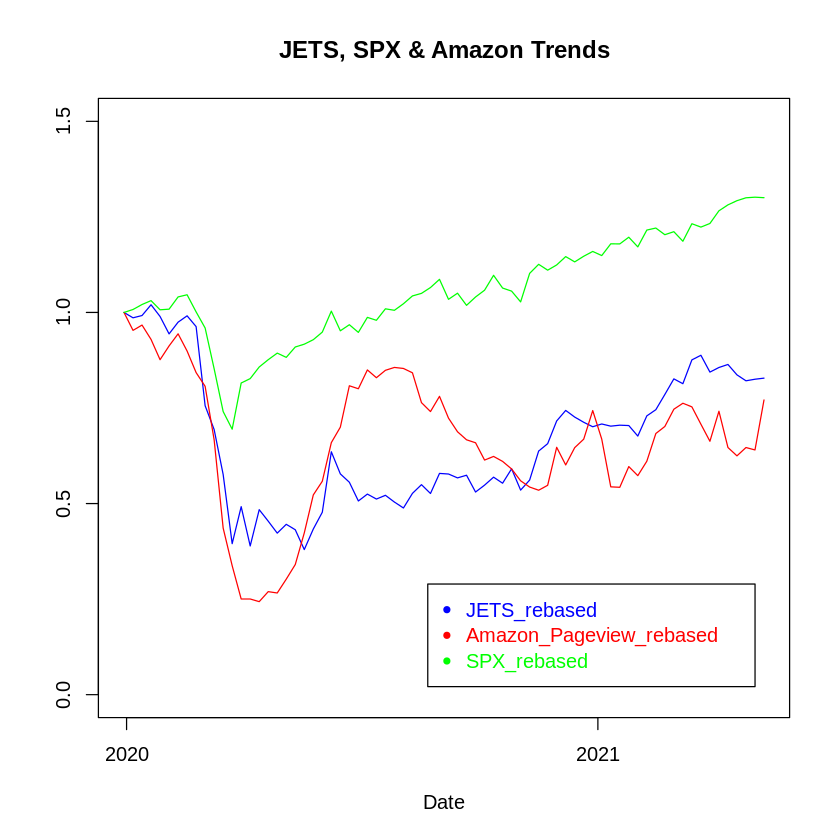

In [22]:
plot(x = to_regress[,1], y = to_regress[,8], type = "l", col = "blue", ylim = c(0,1.5), xlab = "Date", ylab = "", main = "JETS, SPX & Amazon Trends")
lines(x = to_regress[,1], y = to_regress[,9], type = "l", col = "red")
lines(x = to_regress[,1], y = to_regress[,10], type = "l", col = "green")
legend("bottomright", 
        legend = colnames(to_regress)[8:10], 
        col = c("blue", "red", "green"),  
        pch = 20, 
        bty = "o", 
        pt.cex = 1, 
        cex = 1, 
        text.col = c("blue", "red", "green"), 
        inset = c(0.05, 0.05))

## Regressing Arithmetic Weekly JETS Return - CAPM


Call:
lm(formula = to_regress[, 5] ~ to_regress[, 6])

Residuals:
      Min        1Q    Median        3Q       Max 
-0.094933 -0.015480 -0.001766  0.015968  0.109979 

Coefficients:
                Estimate Std. Error t value Pr(>|t|)    
(Intercept)     0.003957   0.003586   1.104    0.274    
to_regress[, 6] 0.245192   0.038080   6.439 1.29e-08 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.03042 on 70 degrees of freedom
Multiple R-squared:  0.372,	Adjusted R-squared:  0.363 
F-statistic: 41.46 on 1 and 70 DF,  p-value: 1.295e-08


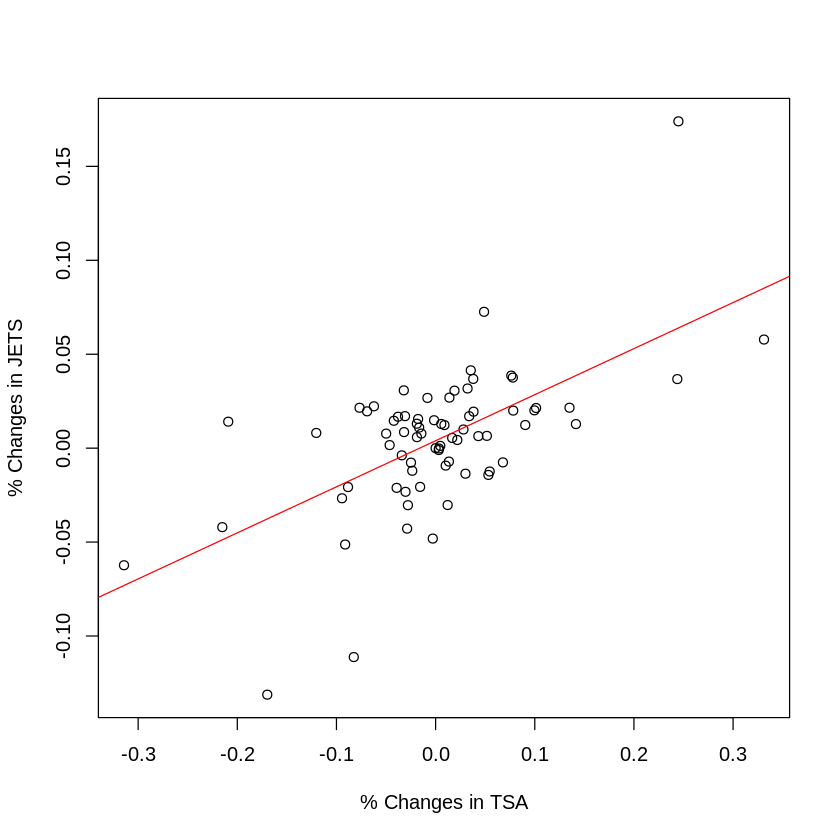

In [23]:
lm_result_1 = lm(to_regress[,5] ~ to_regress[,6]) # i.e. CAPM
summary(lm_result_1)

plot(to_regress[,5] ~ to_regress[,6], xlab = "% Changes in TSA", ylab = "% Changes in JETS")
abline(lm_result_1, col="red")

## Regressing Arithmetic Weekly JETS Return - Alexarank -Amazon Web Trends

In [24]:
lm_result_2 = lm(to_regress[,5] ~ to_regress[,3])
summary(lm_result_2)


Call:
lm(formula = to_regress[, 5] ~ to_regress[, 3])

Residuals:
      Min        1Q    Median        3Q       Max 
-0.104820 -0.020148  0.000353  0.015899  0.192614 

Coefficients:
                Estimate Std. Error t value Pr(>|t|)  
(Intercept)     0.004192   0.004391   0.955   0.3430  
to_regress[, 3] 0.088370   0.042479   2.080   0.0412 *
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.03726 on 70 degrees of freedom
Multiple R-squared:  0.05822,	Adjusted R-squared:  0.04477 
F-statistic: 4.328 on 1 and 70 DF,  p-value: 0.04116


## Regressing Arithmetic Weekly JETS Return - "Improved CAPM with Alexarank(Amazon Web Trends)"

In [25]:
lm_result_3 = lm(to_regress[,5] ~ to_regress[,6] + to_regress[,3]) #"Improved Version 1"
summary(lm_result_3)


Call:
lm(formula = to_regress[, 5] ~ to_regress[, 6] + to_regress[, 
    3])

Residuals:
      Min        1Q    Median        3Q       Max 
-0.089578 -0.013844 -0.000372  0.016535  0.121446 

Coefficients:
                Estimate Std. Error t value Pr(>|t|)    
(Intercept)     0.003903   0.003587   1.088     0.28    
to_regress[, 6] 0.235629   0.039320   5.993  8.4e-08 ***
to_regress[, 3] 0.035113   0.035819   0.980     0.33    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.03043 on 69 degrees of freedom
Multiple R-squared:  0.3806,	Adjusted R-squared:  0.3626 
F-statistic:  21.2 on 2 and 69 DF,  p-value: 6.653e-08


# Prepare Data for Regression

In [26]:
to_regress = data.frame(date = as.Date("1990-01-01"), JETS_weekly_return = 0, Amazon_Pageview_Weekly_Change =0, Amazon_Reach_Weekly_Change=0,SPX_weekly_return = 0,JETS_weekly_excess_return=0,	SPX_weekly_excess_return =0, JETS_rebased = 0, Amazon_Reach_rebased=0, SPX_rebased=0)
for(i in 1:nrow(regression_data_weekly))
{
   if (i == 1) {
      to_regress[i,1] = regression_data_weekly[i,1]
      to_regress[i,8] = 1
      to_regress[i,9] = 1
      to_regress[i,10] = 1
    } 
    else{
 to_regress[i,1] = regression_data_weekly[i,1]
 to_regress[i,2] = (regression_data_weekly[i,2]-regression_data_weekly[i-1,2])/regression_data_weekly[i-1,2]
 to_regress[i,3] = (regression_data_weekly[i,3]-regression_data_weekly[i-1,3])/regression_data_weekly[i-1,3]
 to_regress[i,4] = (regression_data_weekly[i,4]-regression_data_weekly[i-1,4])/regression_data_weekly[i-1,4]
 to_regress[i,5] = (regression_data_weekly[i,5]-regression_data_weekly[i-1,5])/regression_data_weekly[i-1,5]
 to_regress[i,6] = (regression_data_weekly[i,2]-regression_data_weekly[i-1,2])/regression_data_weekly[i-1,2] - regression_data_weekly[i,6]/52/100
 to_regress[i,7] = (regression_data_weekly[i,5]-regression_data_weekly[i-1,5])/regression_data_weekly[i-1,5] - regression_data_weekly[i,6]/52/100
 to_regress[i,8] = to_regress[i-1,8] * (1 + to_regress[i,2])
 to_regress[i,9] = to_regress[i-1,9] * (1 + to_regress[i,4])
 to_regress[i,10] = to_regress[i-1,10] * (1 + to_regress[i,5])
    }
}
tail(to_regress,20)


,date,JETS_weekly_return,Amazon_Pageview_Weekly_Change,Amazon_Reach_Weekly_Change,SPX_weekly_return,JETS_weekly_excess_return,SPX_weekly_excess_return,JETS_rebased,Amazon_Reach_rebased,SPX_rebased
,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
53,2020-12-28,-0.016422597,0.111982592,0.059077601,0.0109448069,-0.016603367,0.0107640377,0.7009552,0.6334364,1.159585
54,2021-01-04,0.010334987,-0.100625746,-0.088237804,-0.0092923317,0.010156141,-0.0094711778,0.7081996,0.5775433,1.148810
55,2021-01-11,-0.008042806,-0.186674403,-0.039096422,0.0267413043,-0.008263960,0.0265201504,0.7025037,0.5549635,1.179531
56,2021-01-18,0.003603603,-0.002159778,-0.034123444,-0.0001842807,0.003392065,-0.0003958192,0.7050352,0.5360262,1.179313
57,2021-01-25,-0.001346544,0.099842021,0.054848662,0.0148595772,-0.001548467,0.0146576541,0.7040859,0.5654265,1.196837
58,2021-02-01,-0.039101169,-0.039721537,-0.035384527,-0.0211394001,-0.039310784,-0.0213490155,0.6765553,0.5454192,1.171537
59,2021-02-08,0.078110387,0.065859538,0.067162109,0.0375557061,0.077881541,0.0373268599,0.7294013,0.5820507,1.215535
60,2021-02-15,0.022125814,0.118660944,0.058998310,0.0043416189,0.021875814,0.0040916189,0.7455399,0.6163907,1.220812
61,2021-02-22,0.053480520,0.027014674,0.027934626,-0.0142628870,0.053217059,-0.0145263485,0.7854117,0.6336093,1.203400


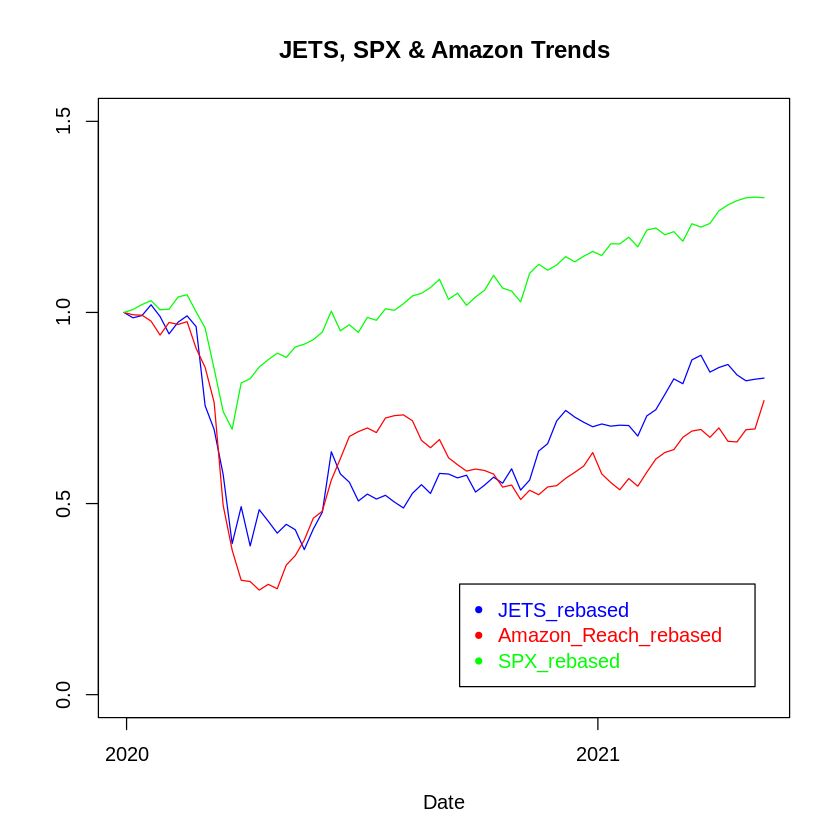

In [27]:
plot(x = to_regress[,1], y = to_regress[,8], type = "l", col = "blue", ylim = c(0,1.5), xlab = "Date", ylab = "", main = "JETS, SPX & Amazon Trends")
lines(x = to_regress[,1], y = to_regress[,9], type = "l", col = "red")
lines(x = to_regress[,1], y = to_regress[,10], type = "l", col = "green")
legend("bottomright", 
        legend = colnames(to_regress)[8:10], 
        col = c("blue", "red", "green"),  
        pch = 20, 
        bty = "o", 
        pt.cex = 1, 
        cex = 1, 
        text.col = c("blue", "red", "green"), 
        inset = c(0.05, 0.05))

## Regressing Arithmetic Weekly JETS Return - CAPM


Call:
lm(formula = to_regress[, 5] ~ to_regress[, 6])

Residuals:
      Min        1Q    Median        3Q       Max 
-0.094933 -0.015480 -0.001766  0.015968  0.109979 

Coefficients:
                Estimate Std. Error t value Pr(>|t|)    
(Intercept)     0.003957   0.003586   1.104    0.274    
to_regress[, 6] 0.245192   0.038080   6.439 1.29e-08 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.03042 on 70 degrees of freedom
Multiple R-squared:  0.372,	Adjusted R-squared:  0.363 
F-statistic: 41.46 on 1 and 70 DF,  p-value: 1.295e-08


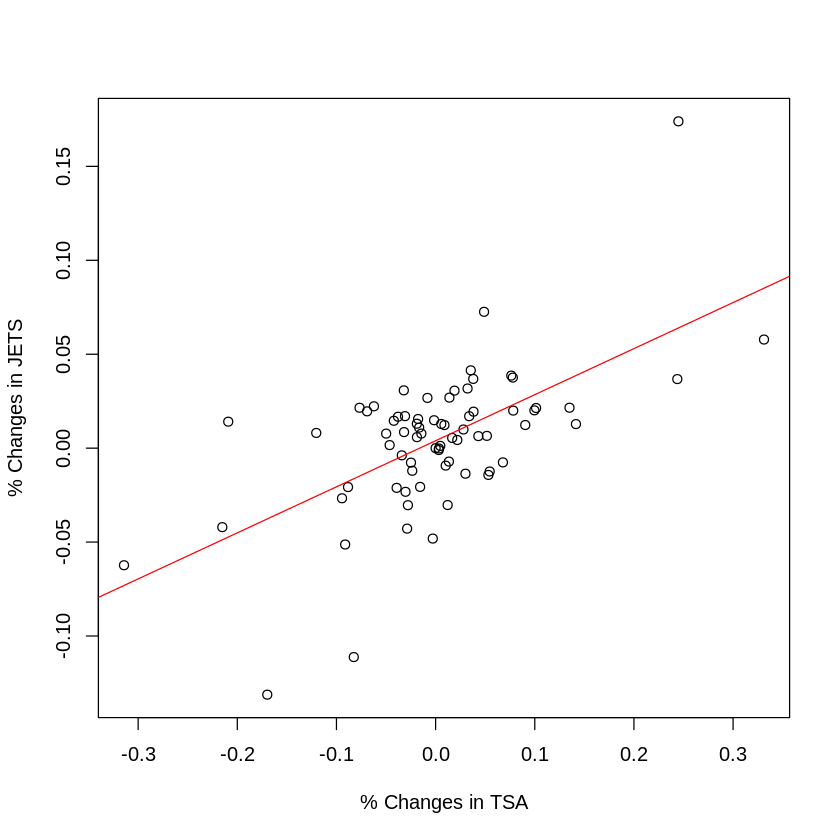

In [28]:
lm_result_1 = lm(to_regress[,5] ~ to_regress[,6]) # i.e. CAPM
summary(lm_result_1)

plot(to_regress[,5] ~ to_regress[,6], xlab = "% Changes in TSA", ylab = "% Changes in JETS")
abline(lm_result_1, col="red")

## Regressing Arithmetic Weekly JETS Return - Alexarank -Amazon Web Trends

In [29]:
lm_result_2 = lm(to_regress[,5] ~ to_regress[,4])
summary(lm_result_2)


Call:
lm(formula = to_regress[, 5] ~ to_regress[, 4])

Residuals:
     Min       1Q   Median       3Q      Max 
-0.10087 -0.02006  0.00174  0.01490  0.19826 

Coefficients:
                Estimate Std. Error t value Pr(>|t|)  
(Intercept)     0.004370   0.004323   1.011   0.3155  
to_regress[, 4] 0.137384   0.053141   2.585   0.0118 *
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.03668 on 70 degrees of freedom
Multiple R-squared:  0.08716,	Adjusted R-squared:  0.07412 
F-statistic: 6.684 on 1 and 70 DF,  p-value: 0.01181


## Regressing Arithmetic Weekly JETS Return - "Improved CAPM with Alexarank(Amazon Web Trends)"

In [30]:
lm_result_3 = lm(to_regress[,5] ~ to_regress[,6] + to_regress[,4]) #"Improved Version 1"
summary(lm_result_3)


Call:
lm(formula = to_regress[, 5] ~ to_regress[, 6] + to_regress[, 
    4])

Residuals:
      Min        1Q    Median        3Q       Max 
-0.090325 -0.013174 -0.000655  0.016963  0.124915 

Coefficients:
                Estimate Std. Error t value Pr(>|t|)    
(Intercept)     0.003983   0.003576   1.114    0.269    
to_regress[, 6] 0.230565   0.039946   5.772 2.04e-07 ***
to_regress[, 4] 0.054553   0.046238   1.180    0.242    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.03034 on 69 degrees of freedom
Multiple R-squared:  0.3844,	Adjusted R-squared:  0.3665 
F-statistic: 21.54 on 2 and 69 DF,  p-value: 5.383e-08
